<a href="https://colab.research.google.com/github/jg051623/selfStudy/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import math

Transformer 

dimension of model : 512
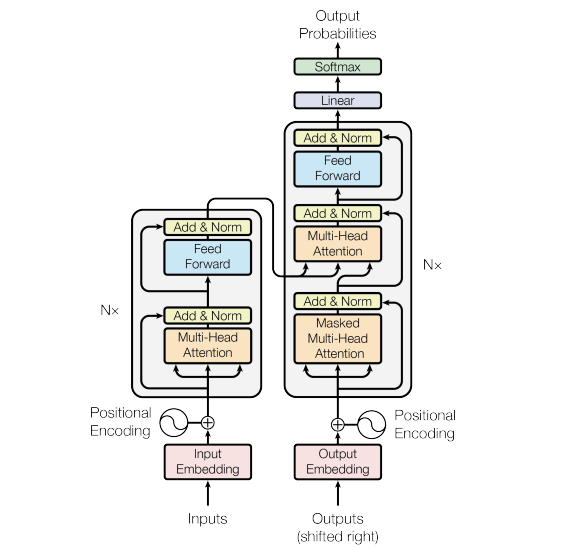

In [5]:
class PositionalEncoding(nn.Module) :
  
  def __init__(self, max_len, d_model, device) :
    super(PositionalEncoding, self).__init__()

    self.encoding = torch.zeros(max_len, d_model, device = device)
    self.encoding.requires_grad = False # don't need to compute gradient

    pos = torch.arange(0, max_len, device = device)
    pos = pos.float().unsqueeze(dim=1)

    _2i = torch.arange(0, d_model, step=2, device=device).float()

    #https://blog.wonkyunglee.io/3
    self.encoding[:,0::2] = torch.sin(pos/(10000**(_2i/d_model)))
    self.encoding[:,1::2] = torch.cos(pos/(10000**(_2i/d_model)))

  def forward(self,x) :
    batch_size, seq_len = x.size()

    return self.encoding[:seq_len,:]

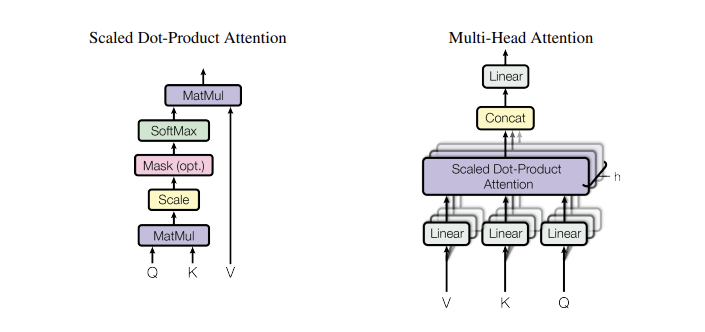

In [17]:
class ScaleDotProductAttention(nn.Module) :

  def __init__(self) :
    super(ScaleDotProductAttention, self).__init__()
    self.softmax = nn.Softmax()

  def forward(self,q,k,v, mask = None, e = 1e-12) :
    # input q,k,v is 4 dim
    # [batch_size, head_num, length, d_key]
    # head_num * d_key = d_model  

    batch_size, head_num, length, d_key = k.size()

    k_t = k.view(batch_size, head_num, d_key, length)
    score = np.matmul(q,k_t) / math.sqrt(d_tensor)


    # masking(optional) : for masked multi-head attention

    if mask is not None :
      score = score.masked_fill(mask == 0, -e)

    score = self.softmax(score)

    v = np.matmul(score, v)

    return v, score

In [26]:
class MultiHeadAttention(nn.Module) :

  def __init__(self, d_model, n_head) :
    super(MultiHeadAttention).__init__()
    self.n_head = n_head
    self.attention = ScaleDotProductAttention()
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_concat = nn.Linear(d_model, d_model)

  def split(self, tensor) :
    '''
    split tensor by number of head

    param tensor = [batch_size, length, d_model]
    output = [batch_size, head_num, length, d_key]

    head_num =  self.n_head
    '''

    batch_size, length, d_model = tensor.size()

    d_key = d_model//self.n_head

    tensor = tensor.view(batch_size, self.n_head, length, d_key)
    
    return tensor

  def concat(self, tensor) :

    '''
    To concatenate tensor into dim_model
    dim_model = dim_key * num_head
    '''
    batch_size, head_num, length, d_key = tensor.size()
    d_model = head_num * d_key

    tensor = tensor.view(batch_size, length, d_model)
    return tensor

  def forward(self, q, k, v, mask = None) :

    q,k,v = self.w_q(q), self.w_k(k), self.w_v(v)

    q,k,v = self.split(q), self.split(k), self.split(v)

    out, attention = self.attention(q,k,v,mask=mask)

    out = self.concat(out)
    out = self.w_concat(out)

    return out
  

In [27]:
# https://kaya-dev.tistory.com/8
class LayerNorm(nn.Module) :
  
  def __init__(self, d_model, eps = 1e-12) :
    super(LayerNorm).__init__()

    self.gamma = nn.Parameter(torch.ones(d_model)) # trainable
    self.beta = nn.Parameter(torch.zeros(d_model)) # trainable
    self.eps = eps

  def forward(self, x) :
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True) 
    # -1 : last dim

    out = (x-mean)/(std + self.eps)
    out = self.gamma * out+self.beta

    return out

In [29]:
class FeedForward(nn.Module) :

  def __init__(self, d_model, hidden, drop_prob = 0.1) :
    super(FeedForward,self).__init__()
    self.linear1 = nn.Linear(d_model, hidden)
    self.linear2 = nn.Linear(hidden, d_model)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=drop_prob)

  def forward(self, x) :
    x = self.lienar1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)

    return x

In [32]:
class EncoderLayer(nn.Module) :
  
  def __init__(self, model, ffn_hidden, n_head, drop_prob = 0.1) :
    self.attention = MultiHeadAttention(d_model, n_head)

    self.norm1 = LayerNorm(d_model = d_model) 
    self.dropout1 = nn.Dropout(p = drop_prob)

    self.ffn = FeedForward(d_model, ffn_hidden)
    
    self.norm2 = LayerNorm(d_model = d_model) 
    self.dropout2 = nn.Dropout(p = drop_prob)

  def forward(self, x, src_mask) :
    _x = x

    x = self.attention(q=x, k=x, v=x, mask = src_mask)

    x = self.norm1(x+_x)
    x = self.dropout1(x)

    _x = x
    x = self.ffn(x)

    x = self.norm2(x+_x)
    x = self.dropout2(x)

    return x



In [39]:
class Encoder(nn.Module) :

  def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, device, drop_prob=0.1) :
    super().__init__()

    # enc_voc_size = vocab size
    # max_len : 한 문장 내 최대 단어 개수

    self.embed = nn.Embedding(enc_voc_size, d_model)
    self.pe = PositionalEncoding(max_len,d_model,device)
    self.layers = nn.ModuleList([EncoderLayer(d_model,ffn_hidden,n_head) for _ in range(n_layers)])

  def forward(self,x,src_mask) :
    x = self.emb(x)
    x_pe = self.pe(x)

    x = x+x_pe

    for layer in self.layers :
      x = layer(x, src_mask)

    return x  # This is output of encoder

In [42]:
class DecoderLayer(nn.Module) :
  def __init__(self, d_model, ffn_hidden, n_head, drop_prob=0.1) :
    super().__init__()
    self.self_attention = MultiHeadAttention(d_model, n_head) 

    self.norm1 = LayerNorm(d_model) 
    self.dropout1 = nn.Dropout(p=drop_prob)

    self.enc_dec_attention = MultiHeadAttention(d_model, n_head) 

    self.norm2 = LayerNorm(d_model) 
    self.dropout2 = nn.Dropout(p=drop_prob)

    self.ffn = FeedForward(d_model, ffn_hidden)

    self.norm3 = LayerNorm(d_model) 
    self.dropout3 = nn.Dropout(p=drop_prob)

  def forward(self,dec,enc,trg_mask,src_mask) :

    _x = dec

    x = self.self_attention(q=dec, k=dec, v=dec, mask = trg_mask)

    x = self.norm1(x + _x)
    x = self.dropout1(x)

    if enc is not None :
      _x = x

      # query : decoder self attention output
      # key & value : encoder output

      x = self.enc_dec_attention(q = x, k = enc, v= enc, mask = src_mask)

      x = self.norm2(x+_x)
      x = self.dropout2(x)

    _x = x

    x = self.ffn(x)
    x = self.norm3(x + _x)
    x = self.dropout3(x)

    return x

In [44]:
class Decoder(nn.Module) :
  def __init__ (self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, device, drop_prob = 0.1) :
    super().__init__()

    self.embed = nn.Embedding(dec_voc_size, d_model) 

    self.pe = PositionalEncoding(max_len, d_model, device = 'cuda')

    self.layers = nn.ModuleList([DecoderLayer(d_model, ffn_hidden, n_head) for _ in range(n_layers)])
    self.linear = nn.Linear(d_model, dec_voc_size)

  def forward(self, trg, src, trg_mask, src_mask) :

    trg = self.embed(trg)

    trg_pe = self.pe(trg)
    trg = trg + trg_pe

    for layer in self.layers :
      trg = layer(trg, src,trg_mask, src_mask)

    output = self.linear(trg)

    return output

In [53]:
class Transformer(nn.Module):
    
    def __init__(self,src_pad_idx,trg_pad_idx,trg_sos_idx,enc_voc_size,dec_voc_size,d_model,n_head,max_len,
                ffn_hidden,n_layers,drop_prob,device):
        super().__init__()
        #Get <PAD> idx
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        
        #Encoder
        self.encoder = Encoder(enc_voc_size = enc_voc_size,
                              max_len = max_len,
                              d_model = d_model,
                              ffn_hidden = ffn_hidden,
                              n_head = n_head,
                              n_layers = n_layers,
                              drop_prob = drop_prob,
                              device = device)
        
        #Decoder
        self.decoder = Decoder(dec_voc_size = dec_voc_size,
                              max_len = max_len,
                              d_model = d_model,
                              ffn_hidden = ffn_hidden,
                              n_head = n_head,
                              n_layers = n_layers,
                              drop_prob = drop_prob,
                              device = device)
        self.device = device
    
    def make_pad_mask(self,q,k):
    
    	#Padding부분은 attention연산에서 제외해야하므로 mask를 씌워줘서 계산이 되지 않도록 한다.
        
        len_q,len_k = q.size(1),k.size(1)
        print(len_k)
        #batch_size x 1 x 1 x len_k
        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        print(k.shape)
        # batch_size x1 x len_1 x len_k
        k = k.repeat(1,1,len_q,1)
        
        #batch_size x 1 x len_q x 1
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        #batch_size x 1 x len_q x len_k
        q = q.repeat(1,1,1,len_k)
        
        mask = k & q
        
        return mask
    
    def make_no_peak_mask(self,q,k):
    	
        #Decoder 부분에서 t번째 단어를 예측하기 위해 입력으로 t-1번째 단어까지 넣어야 하므로 나머지 부분을 masking처리 한다.
        #만약 t번째 단어를 예측하는데 이미 decoder에 t번째 단어가 들어간다면?? => 답을 이미 알고 있는 상황..
        #따라서 Seq2Seq 모델에서 처럼 t번째 단어를 예측하기 위해서 t-1번째 단어까지만 입력될 필요가 있음
        #(나머지 t,t+1,...,max_len)까지 단어는 t번째 단어를 예측하는데 전혀 필요하지 않음 => Masking!!
        len_q,len_k = q.size(1),k.size(1)
        
        #len_q x len_k (torch.tril = 하삼각행렬)
        mask = torch.tril(torch.ones(len_q,len_k)).type(torch.BoolTensor).to(self.device)
        
        return mask
    
    def forward(self,src,trg):
    	
        #Get Mask
        src_mask = self.make_pad_mask(src,src)
        src_trg_mask = self.make_pad_mask(trg,src)
        trg_mask = self.make_pad_mask(trg,trg) * self.make_no_peak_mask(trg,trg)
        
        #Compute Encoder
        enc_src = self.encoder(src,src_mask)
        
        #Compute Decoder
        output = self.decoder(trg,enc_src,trg_mask,src_trg_mask)
        
        return output